In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

# Read in FantasyFootballAnalytics Data

In [2]:
df = pd.read_csv('ffa_customrankings2019-0.csv')

In [3]:
df.head()

,playerId,player,team,position,age,exp,bye,lower,upper,sdPts,...,positionRank,ptsGame,vorGame,vorGameLow,vorGameHigh,adp,auctionValue,adpDiff,cost,ppdollar
0,2560968,Saquon Barkley,NYG,RB,22.0,1.0,11.0,292.187000,356.878658,27.465896,...,1,20.667914,13.737235,13.362149,13.737704,1.3125,67.9167,-0.3125,75,4.409155
1,2558019,Alvin Kamara,NO,RB,23.0,2.0,9.0,289.191471,325.254722,14.041320,...,2,19.051325,12.120645,13.174928,11.761208,2.7450,65.7533,-0.7450,73,4.175633
2,2557997,Christian McCaffrey,CAR,RB,23.0,2.0,7.0,275.300000,329.551517,21.842973,...,3,18.965151,12.034472,12.306711,12.029757,3.2625,64.8667,-0.2625,72,4.214478
3,2558125,Patrick Mahomes,KC,QB,NaN,2.0,12.0,337.665627,385.997960,25.439581,...,1,22.598085,10.897159,17.063284,9.886506,18.4825,30.1033,-14.4825,34,10.634393
4,2555224,Ezekiel Elliott,DAL,RB,24.0,3.0,8.0,234.057000,311.149123,33.221537,...,4,17.679461,10.748782,10.014820,11.259538,5.5150,58.8467,-0.5150,65,4.268475


In [4]:
df.columns

Index(['playerId', 'player', 'team', 'position', 'age', 'exp', 'bye', 'lower',
       'upper', 'sdPts', 'dropoff', 'tier', 'ptSpread', 'overallECR',
       'positionECR', 'sdRank', 'risk', 'sleeper', 'games', 'points', 'vor',
       'vorLow', 'vorHigh', 'overallRank', 'positionRank', 'ptsGame',
       'vorGame', 'vorGameLow', 'vorGameHigh', 'adp', 'auctionValue',
       'adpDiff', 'cost', 'ppdollar'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 34 columns):
playerId        728 non-null int64
player          728 non-null object
team            728 non-null object
position        728 non-null object
age             621 non-null float64
exp             695 non-null float64
bye             608 non-null float64
lower           728 non-null float64
upper           728 non-null float64
sdPts           696 non-null float64
dropoff         724 non-null float64
tier            728 non-null int64
ptSpread        728 non-null float64
overallECR      463 non-null float64
positionECR     599 non-null float64
sdRank          599 non-null float64
risk            617 non-null float64
sleeper         180 non-null float64
games           728 non-null float64
points          728 non-null float64
vor             728 non-null float64
vorLow          728 non-null float64
vorHigh         728 non-null float64
overallRank     728 non-null int64
positionRank    

Here I will only work with 'above replacement' players (i.e. players that will get drafted). Let's take a look at some of the statistics

In [7]:
above_replacement = df[df['vor'] > 0.0].copy()
above_replacement[['player', 'vor', 'cost', 'overallRank']].describe()

,vor,cost,overallRank
count,138.000000,138.000000,138.000000
mean,66.348677,15.724638,70.094203
std,48.035276,18.939307,40.711176
min,0.077014,2.000000,1.000000
25%,26.529423,3.000000,35.250000
50%,59.228635,6.000000,69.500000
75%,101.792395,22.250000,105.750000
max,220.939627,75.000000,140.000000


In [28]:
dollar_per_vor = above_replacement['vor'].sum()/2000.0
print('dollar per vor:', dollar_per_vor)

dollar per vor: 4.578058737569661


In [29]:
# add a column that calculates how much each player should be worth based on the 4.6 overall dollars per VOR
above_replacement[['dollarVor']] = above_replacement[['vor']] / dollar_per_vor

In [10]:
above_replacement.head()

,playerId,player,team,position,age,exp,bye,lower,upper,sdPts,...,ptsGame,vorGame,vorGameLow,vorGameHigh,adp,auctionValue,adpDiff,cost,ppdollar,dollarVor
0,2560968,Saquon Barkley,NYG,RB,22.0,1.0,11.0,292.187000,356.878658,27.465896,...,20.667914,13.737235,13.362149,13.737704,1.3125,67.9167,-0.3125,75,4.409155,48.260549
1,2558019,Alvin Kamara,NO,RB,23.0,2.0,9.0,289.191471,325.254722,14.041320,...,19.051325,12.120645,13.174928,11.761208,2.7450,65.7533,-0.7450,73,4.175633,42.610681
2,2557997,Christian McCaffrey,CAR,RB,23.0,2.0,7.0,275.300000,329.551517,21.842973,...,18.965151,12.034472,12.306711,12.029757,3.2625,64.8667,-0.2625,72,4.214478,42.309509
3,2558125,Patrick Mahomes,KC,QB,NaN,2.0,12.0,337.665627,385.997960,25.439581,...,22.598085,10.897159,17.063284,9.886506,18.4825,30.1033,-14.4825,34,10.634393,38.084821
4,2555224,Ezekiel Elliott,DAL,RB,24.0,3.0,8.0,234.057000,311.149123,33.221537,...,17.679461,10.748782,10.014820,11.259538,5.5150,58.8467,-0.5150,65,4.268475,36.632090


# Analysis

First, let's take a look at the typical amount spent for each player. It seems that QBs are in typically underpriced.

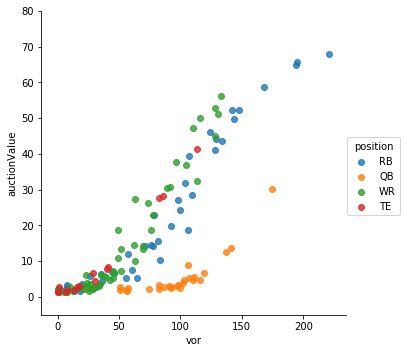

In [12]:
sns.lmplot('vor', 'auctionValue', data=above_replacement, hue='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('aav_all.png')

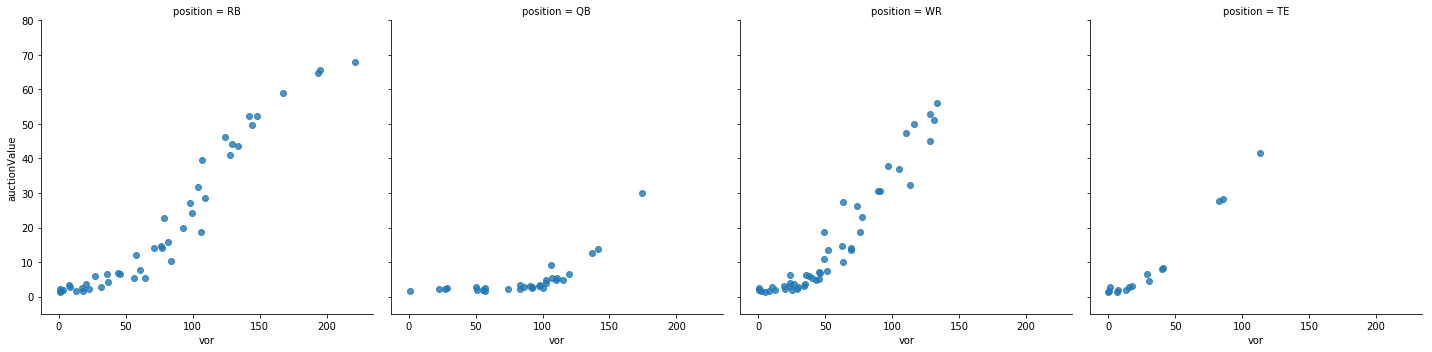

In [13]:
sns.lmplot('vor', 'auctionValue', data=above_replacement, col='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('aav_pos.png')

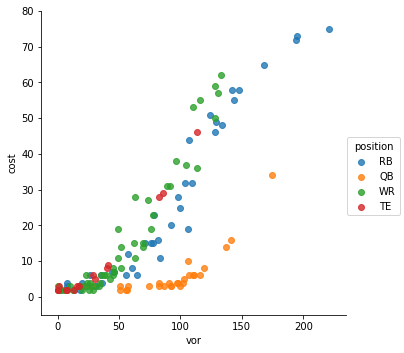

In [14]:
sns.lmplot('vor', 'cost', data=above_replacement, hue='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('cost_all.png')

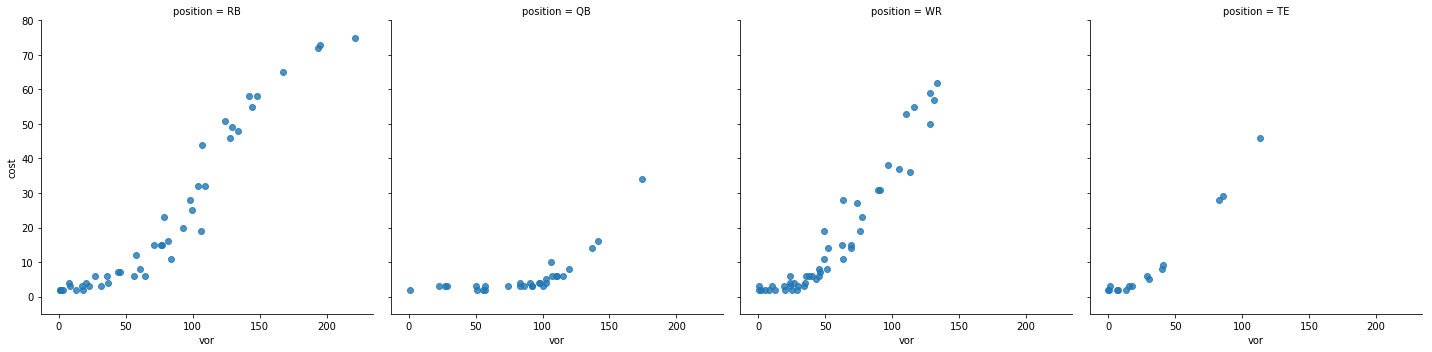

In [15]:
sns.lmplot('vor', 'cost', data=above_replacement, col='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('cost_pos.png')

## New Cost
If we assign a linear relationship for cost per VOR, we can generate a linear relationship that keeps costs down.

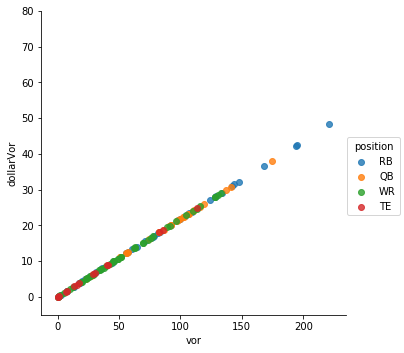

In [16]:
sns.lmplot('vor', 'dollarVor', data=above_replacement, hue='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('straight_all.png')

But, it is much harder to replace the best players, and these typically go for higher dollar amounts. Instead, apply a sigmoid function to increase the cost for higher players and decrease the cost

In [17]:
rbs = above_replacement[above_replacement['position'] == 'RB']

In [18]:
# def my_tanh(x, x_0, a, b):
#     return a * np.cos(b * (x - x_0))

def fsigmoid(x, a, b, c):
    return c / (1.0 + np.exp(-a*(x-b)))

params, params_covariance = optimize.curve_fit(fsigmoid, rbs['vor'], rbs['cost'])

print(params)

/Users/morris/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


[3.59514652e-02 1.15693701e+02 7.67816378e+01]


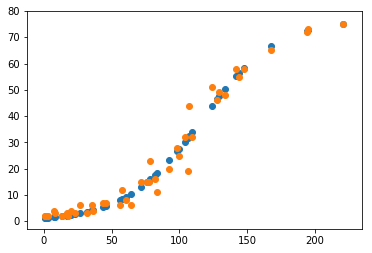

In [19]:
my_x = np.arange(0,200)
plt.scatter(rbs['vor'], fsigmoid(rbs['vor'], *params))
plt.scatter(rbs['vor'], rbs['cost'])

In [20]:

above_replacement[['moe_cost']] = fsigmoid(above_replacement[['vor']] , *params)

scale_cost = 2000 / above_replacement[['moe_cost']].sum()
above_replacement[['moe_cost']] = above_replacement[['moe_cost']] * scale_cost

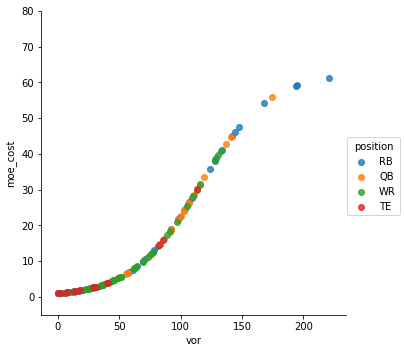

In [21]:
# call regplot on each axes
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
#sns.regplot(x=idx, y=df['x'], ax=ax1)
#sns.regplot(x=idx, y=df['y'], ax=ax2)

sns.lmplot('vor', 'moe_cost', data=above_replacement, hue='position', fit_reg=False)
plt.ylim(-5,80)
plt.savefig('moe_all.png')

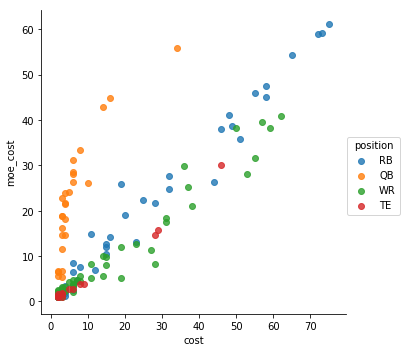

In [22]:
sns.lmplot('cost', 'moe_cost', data=above_replacement, hue='position', fit_reg=False)
plt.savefig('moe_comp.png')

In [23]:
above_replacement[['moe_cost']].sum()

moe_cost    2000.0
dtype: float64